# Sign language assignment
## Yoav Ram

In [67]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Ex 1: Object detection with generalized linear models

In this exercise we develop a model for object detection in images. Specifically, we will train the model to detect the area of an image in which a hand appears and displays a sign from a sign language.

We will develop a model that, given an image $\bf x$ (an array of pixels) , produces a bounding box ${\bf y}$.
The bounding box is a rectangle defined by his top-left and bottom-right corners. Hence ${\bf y}=(y_1, y_2, y_3, y_4)$.
The detected object -- a hand gesturing a sign -- is to be inside this bounding box.

This is a supervised learning problem, as we have a set of images with their corresponding bounding boxes.

## Data

We will use a [sign language dataset](https://medium.freecodecamp.org/weekend-projects-sign-language-and-static-gesture-recognition-using-scikit-learn-60813d600e79) that includes both images and bounding box data.
We'll develop a model that learns to **predict the bounding boxes** of hands gesturing signs in images.

Let's get the data:

In [1]:
import os
import urllib.request

fname = '../data/sign-lang.zip'
url = 'https://github.com/yoavram/Sign-Language/raw/master/Dataset.zip'
if not os.path.exists(fname):
    urllib.request.urlretrieve(url, fname)
print(fname, 'exists:', os.path.exists(fname))

../data/sign-lang.zip exists: True


In [2]:
import zipfile

folder = fname.replace('.zip', '')
if not os.path.exists(folder):
    print('Extracting to {}'.format(folder))
    with zipfile.ZipFile(fname) as f:
        f.extractall('../data/')
    os.rename('../data/Dataset', folder)
print(folder, 'exists:', os.path.exists(folder))

../data/sign-lang exists: True


We have folder for different users; each user folders has JPEG images and a single metadata CSV file.

In [3]:
%ls ../data/sign-lang
%ls ../data/sign-lang/user_5/

user_10/ user_3/  user_4/  user_5/  user_6/  user_7/  user_9/
A0.jpg          E9.jpg          K8.jpg          P7.jpg          U6.jpg
A1.jpg          F0.jpg          K9.jpg          P8.jpg          U7.jpg
A2.jpg          F1.jpg          L0.jpg          P9.jpg          U8.jpg
A3.jpg          F2.jpg          L1.jpg          Q0.jpg          U9.jpg
A4.jpg          F3.jpg          L2.jpg          Q1.jpg          V0.jpg
A5.jpg          F4.jpg          L3.jpg          Q2.jpg          V1.jpg
A6.jpg          F5.jpg          L4.jpg          Q3.jpg          V2.jpg
A7.jpg          F6.jpg          L5.jpg          Q4.jpg          V3.jpg
A8.jpg          F7.jpg          L6.jpg          Q5.jpg          V4.jpg
A9.jpg          F8.jpg          L7.jpg          Q6.jpg          V5.jpg
B0.jpg          F9.jpg          L8.jpg          Q7.jpg          V6.jpg
B1.jpg          G0.jpg          L9.jpg          Q8.jpg          V7.jpg
B2.jpg          G1.jpg          M0.jpg          Q9.jpg          V8.jpg
B3.jpg         

We'll read the images with imageio.

In [4]:
import imageio

def open_image(fname):
    return imageio.imread(fname)

im = open_image(os.path.join(folder, 'user_3', 'A0.jpg'))
print(im.dtype, im.shape)

uint8 (240, 320, 3)


We'll plot the images with matplotlib.

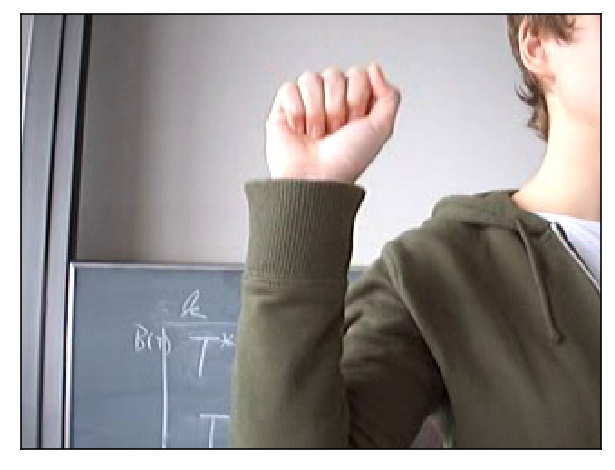

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def display_image(im, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(im)
    ax.set(xticks=[], yticks=[])
    return ax

display_image(im);

We can open the metadata CSV file with pandas.

In [6]:
import pandas as pd

def open_metadata(fname):
    return pd.read_csv(fname)

In [7]:
metadata_fname = os.path.join(folder, 'user_3', 'user_3_loc.csv')
metadata = open_metadata(metadata_fname)
metadata.head()

,image,top_left_x,top_left_y,bottom_right_x,bottom_right_y
0,user_3/A0.jpg,124,18,214,108
1,user_3/A1.jpg,124,18,214,108
2,user_3/A2.jpg,123,19,213,109
3,user_3/A3.jpg,122,21,212,111
4,user_3/A4.jpg,122,20,212,110


The metadata has the filename (which actually specifies the user and the sign), as well as the xs and ys of the bounding box of the gesturing hand.

## Bounding boxes

OK, let's see how those `x`s and `y`s relate to the image.

**Redefine `display_image(im, *boxes)`** to take an arbitrary number of boxs (tuples of top-left-x, top-left-y, bottom-right-x, bottom-right-y) and plot the image with the corresponding boxes.
Boxes can be plotted using `plt.Rectangle`, which, after being created, needs to be added to the axes using `ax.add_artist`.

Plot each supplied box with a different color and style; later, we will use this function to plot both the true box and the predicted box.

In [8]:
row = metadata[metadata['image']=='user_3/A0.jpg']
tlx, tly, brx, bry = [
    row[k].values[0]
    for k in ['top_left_x', 'top_left_y', 'bottom_right_x', 'bottom_right_y']
]

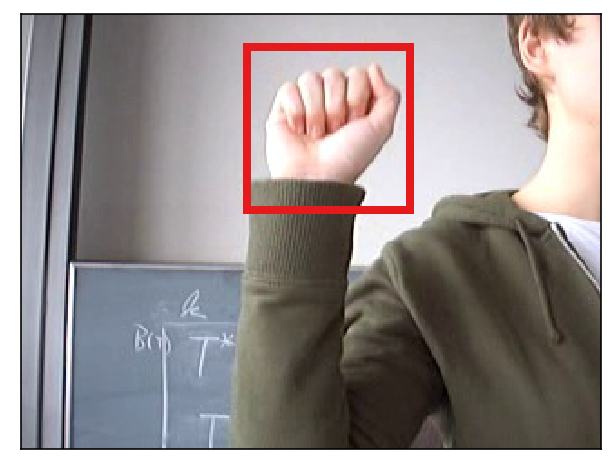

In [9]:
import seaborn as sns
from ipywidgets import interact

def display_image(im, *boxes, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(im)
    ax.set(xticks=[], yticks=[])
    for box, c, ls in zip(boxes, sns.color_palette('Set1'), ['-', '--']):
        tlx, tly, brx, bry = box
        rect = plt.Rectangle((tlx, bry), brx-tlx, tly-bry, 
                             fill=False, color=c, lw=4, ls=ls)
        ax.add_artist(rect)
    return ax

display_image(im, [tlx, tly, brx, bry]);

## Collect images and boxes

Now, let's **create the $X$ array that contains all the image data**, with the first axis as the samples (or example), and **create the $Y$ array that contain all the bounding box examples**, again with the first axis being the sample/example.

In [10]:
metadata_fnames = []
for dirpath, dirnames, filenames in os.walk(folder):
    for fname in filenames:
        if fname.endswith('.csv'):
            metadata_fnames.append(os.path.join(dirpath, fname))
metadata_fnames

['../data/sign-lang/user_5/user_5_loc.csv',
 '../data/sign-lang/user_3/user_3_loc.csv',
 '../data/sign-lang/user_4/user_4_loc.csv',
 '../data/sign-lang/user_6/user_6_loc.csv',
 '../data/sign-lang/user_9/user_9_loc.csv',
 '../data/sign-lang/user_7/user_7_loc.csv',
 '../data/sign-lang/user_10/user_10_loc.csv']

In [11]:
metadata = pd.concat(pd.read_csv(fname) for fname in metadata_fnames)
print(metadata.shape)
metadata.head()

(1680, 5)


,image,top_left_x,top_left_y,bottom_right_x,bottom_right_y
0,user_5/A0.jpg,181,92,271,182
1,user_5/A1.jpg,180,95,270,185
2,user_5/A2.jpg,180,97,270,187
3,user_5/A3.jpg,180,98,270,188
4,user_5/A4.jpg,179,103,269,193


In [12]:
import numpy as np

images = [open_image(os.path.join(folder, fname)) for fname in metadata['image']]
images = np.array(images)
n_samples, width, height, channels = images.shape
X = images.reshape(n_samples, -1)

In [13]:
X = X / 255

In [14]:
Y = metadata[['top_left_x', 'top_left_y', 'bottom_right_x', 'bottom_right_y']]

## Model fitting

**Split the data** into training and testing sets.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y.values, test_size=0.25, random_state=9)

**Train a model** to predict the bounding box for each image.
Use linear regression, as there is no need here for neural networks.
This may take a few minutes.

**Print the score** of the model on the test data.

In [18]:
from sklearn import linear_model

lm = linear_model.LinearRegression(fit_intercept=False, n_jobs=-1)
lm.fit(X_train, Y_train)

LinearRegression(fit_intercept=False, n_jobs=-1)

In [19]:
print("Score: {}".format(lm.score(X_test, Y_test)))

Score: 0.9159213813537929


We [serialize the model to a file](http://scikit-learn.org/stable/modules/model_persistence.html) to be used later.

In [20]:
import pickle

In [21]:
if input("Are you sure? (N/y)").lower() == 'y':
    with open('../data/sign-lang-lm.pkl', 'wb') as f:
        pickle.dump(lm, f)

Are you sure? (N/y) y


Load model from file:

In [22]:
with open('../data/sign-lang-lm.pkl', 'rb') as f:
    lm = pickle.load(f)

## Evaluation and visualization

To measure the model performence we will use a special metric: IoU - intersection over union.

The following demonstrates the intuition behind IoU:

![IoU](https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

![IoU](https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_examples.png)

You can read more and see an implementation [here](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

**Implement the IoU(box1, box2) function**. 
It should work on arrays, using broadcasing.

Hint: use `np.minimum` and `np.maxmimum`.

Make sure that the function returns an array even if it recieved single boxes, rather than arrays of boxes.

In [23]:
def IoU(box1, box2):
    if box1.ndim == 1:
        box1 = np.expand_dims(box1, axis=0)
    if box2.ndim == 1:
        box2 = np.expand_dims(box2, axis=0)

    tlx1, tly1, brx1, bry1 = box1.T
    tlx2, tly2, brx2, bry2 = box2.T
    zero_idx = (tlx1 >= brx1) | (tly1 >= bry1) | (tlx2 >= brx2) | (tly2 >= bry2)


    dx = np.minimum(brx1, brx2) - np.maximum(tlx1, tlx2)
    dy = np.minimum(bry1, bry2) - np.maximum(tly1, tly2)
    inter_area = dx * dy
    inter_area[zero_idx] = 0

    area1 = (brx1 - tlx1) * (bry1 - tly1)
    area2 = (brx2 - tlx2) * (bry2 - tly2)
    union_area = area1 + area2 - inter_area

    return inter_area / union_area

**Visualize the model** results by writing a function `plot_prediction` that
- plots an image from the test set,
- plots its true bounding box in red,
- plots its predicted bounding box in blue,
- prints the two bounding boxes,
- prints the IoU.

The plots can be done using `display_image` from above.

Wrap this plotting function with `ipywidgets.interact` to produce a slider; moving the slider should switch an image.
ipywidgets is a bit tricky to install, follow the [online instruction](http://ipywidgets.readthedocs.io).

In [24]:
def true_box(idx):
    return Y_test[idx]

def predict_box(idx, model):
    X_ = X_test[idx]
    if X_.ndim == 1:
        X_ = X_.reshape(1, -1)
    return model.predict(X_).ravel().astype(int)

def plot_prediction(idx):
    im = X_test[idx].reshape(width, height, channels)
    pred = predict_box(idx, model=lm)
    truth = true_box(idx)
    display_image(im, pred, truth);
    print('predicted box: \t', pred)
    print('real box: \t', truth)
    print('IoU = {:.2f}'.format(IoU(pred, truth)[0]))

In [25]:
from ipywidgets import interact

interact(plot_prediction, idx=(0, X_test.shape[0]-1));

interactive(children=(IntSlider(value=209, description='idx', max=419), Output()), _dom_classes=('widget-inter…

Now 
1. **Compute the scores (IoU) over all the test images**.
1. Make sure that all scores are between 0 and 1.
1. **Print the mean, 95% confidence interval of scores**.
1. **Plot a histogram of the scores**.
1. **Plot the mean and CI** over the histogram using `plt.axvline` and `plt.fill_between`.

In [26]:
truth = Y_test
pred = lm.predict(X_test)
scores = IoU(pred, truth)

In [27]:
assert (0 <= scores).all()
assert (1 >= scores).all()

avg = scores.mean()
low, high = np.percentile(scores, 2.5), np.percentile(scores, 97.5)
print("Mean IoU {:.3f}".format(avg))
print("95% CI {:.3f}-{:.3f}".format(low, high))

Mean IoU 0.776
95% CI 0.521-0.961


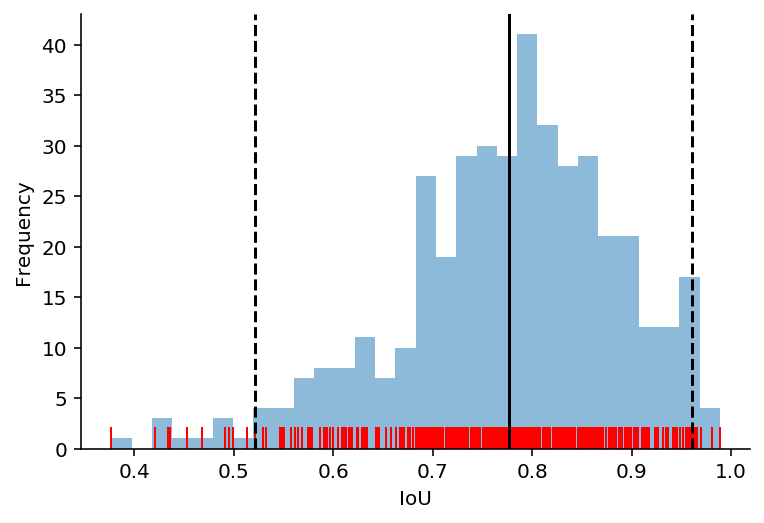

In [28]:
counts, bins, _ = plt.hist(scores, bins=30, alpha=0.5)
sns.rugplot(scores, ax=plt.gca(), color='r')
plt.axvline(scores.mean(), color='k', ls='-')
plt.axvline(low, color='k', ls='--')
plt.axvline(high, color='k', ls='--')
plt.xlabel('IoU')
plt.ylabel('Frequency')
sns.despine()

# Ex 2: Classification of sign language hand gestures with CNN

This exercise is a continuation of the previous one, but can be solved separately.
In the previous exercise we developed a model to detect the region of an image in which there is a hand gesturing signs.
In this exercise we will develop a model to classify the hand gestures to one of a a set of signs.

Go through Ex 2 sections _Data_, and _Bounding boxes_, and continue below.

## Bounding boxes

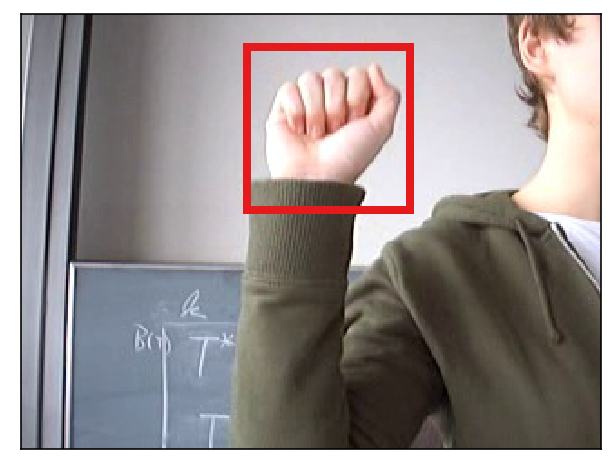

In [56]:
row = metadata[metadata['image']=='user_3/A0.jpg']
tlx, tly, brx, bry = [
    row[k].values[0]
    for k in ['top_left_x', 'top_left_y', 'bottom_right_x', 'bottom_right_y']
]

display_image(im, [tlx, tly, brx, bry]);

Now **implement `crop(im, box)`** that takes an image array `im` and a bounding box `(tlx, tly, brx, bry)` and returns an array containing only the image inside the bounding box.

In [57]:
def crop(im, box):
    tlx, tly, brx, bry = box
    return im[tly:bry, tlx:brx]

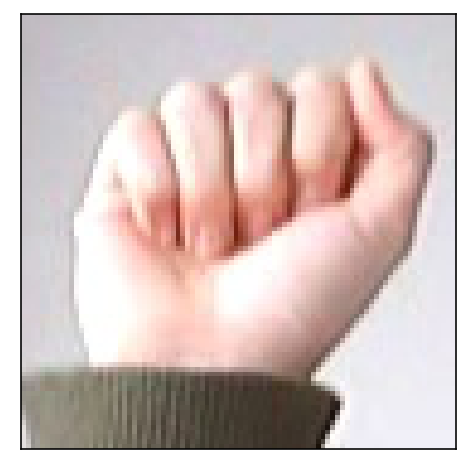

In [58]:
display_image(crop(im, [tlx, tly, brx, bry]));

## Collect images and classes

Now, let's **create the $X$ array** that contains all the _cropped images_, with the first axis as the samples (or example), and **create the $Y$ array** that contain all the classes, again with the first axis being the sample/example.

Reminder:
- $X$ should be 4D with shape `(1680, width, height, 3)`. `width` and `height` are your choices, see below.
- $Y$ should be 2D with shape `(1680, 24)`.


Note that each cropped image has a different shape.
[Resize or rescale](http://scikit-image.org/docs/dev/auto_examples/transform/plot_rescale.html) them to a common shape: this is a requirement for convolutional neural networks, which cannot work on variable array sizes.

Note 1: cropping and resizing/rescaling must be done in a separate function, called `preprocess(im, box, width, height)` that takes an image array, a bounding box for cropping, and width and height for resizing, and returns the resized cropped image. This is important so that latter we can preprocess images before feeding them to the model for prediction.

Note 2: you should also already prepare a function for decoding predictions, called `decode(yhat)` that will take the model ouptut and return a string with the predicted label. The true classifications (i.e. labels) are given in the image filenames, which also appear in the metadata table.

In [59]:
metadata_fnames = []
for dirpath, dirnames, filenames in os.walk(folder):
    for fname in filenames:
        if fname.endswith('.csv'):
            metadata_fnames.append(os.path.join(dirpath, fname))
metadata_fnames

['../data/sign-lang/user_5/user_5_loc.csv',
 '../data/sign-lang/user_3/user_3_loc.csv',
 '../data/sign-lang/user_4/user_4_loc.csv',
 '../data/sign-lang/user_6/user_6_loc.csv',
 '../data/sign-lang/user_9/user_9_loc.csv',
 '../data/sign-lang/user_7/user_7_loc.csv',
 '../data/sign-lang/user_10/user_10_loc.csv']

In [60]:
metadata = pd.concat(pd.read_csv(fname) for fname in metadata_fnames)
metadata.head()

,image,top_left_x,top_left_y,bottom_right_x,bottom_right_y
0,user_5/A0.jpg,181,92,271,182
1,user_5/A1.jpg,180,95,270,185
2,user_5/A2.jpg,180,97,270,187
3,user_5/A3.jpg,180,98,270,188
4,user_5/A4.jpg,179,103,269,193


In [61]:
import numpy as np
from skimage import transform

img_shape = (100, 100, 3)

def preprocess(im, box):
    im = crop(im, box).astype('float32')
    im = transform.resize(im, img_shape, mode='constant', anti_aliasing=True)
    im /= 255
    return im

def dataframe_to_X(df):
    X = []
    for _, row in df.iterrows():
        fname = row['image']
        im = open_image(os.path.join(folder, fname))
        box = row[['top_left_x', 'top_left_y', 'bottom_right_x', 'bottom_right_y']]    
        im = preprocess(im, box)
        X.append(im)
    return np.array(X, dtype='float32')

In [62]:
X = dataframe_to_X(metadata)

In [63]:
metadata['label'] = [fname.split('/')[-1].split('.')[0][0] for fname in metadata['image']]
letters = list(np.unique(metadata['label']))
print(letters)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


In [68]:
import keras

nclass = len(letters)

def encode(labels):
    Y = [letters.index(c) for c in labels]
    return keras.utils.to_categorical(Y, num_classes=nclass)

def decode(Yhat):
    pred = Yhat.argmax()
    return letters[pred]

Y = encode(metadata['label'])

In [69]:
X.dtype, Y.dtype, X.shape, Y.shape, X.min(), X.max()

(dtype('float32'), dtype('float32'), (1680, 100, 100, 3), (1680, 24), 0.0, 1.0)

**Split the dataset to training and testing sets**.
Use the `stratify` keyword of `train_test_split` to make sure that you get equal amounts of each class in the test set.

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=metadata['label'], test_size=0.25)

## Model fitting

**Build and train** a convolutional neural network.

- You can start with a network similar to that used in Lecture 13 and Assignment 5, and increase the complexity if it's not good enough.
- Consider using `BatchNormalization` as a replacement for `Dropout`.
- You can work on Google Colaboratory, which provides free access to a GPU; see Assignment 5 for some more details.
- Make sure you train on the train set and evaluate on the test set.

When training is done, **save the model to a file and print the its accuracy on a test set**.

Hint: you should be able to achieve accuracy of >85% on the test set.

In [71]:
cnn_layers = (32, 64, 128)
dense_units = 256

model = keras.Sequential()
for n_kernels in cnn_layers:
    model.add(keras.layers.Conv2D(n_kernels, (5,5)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(dense_units))
model.add(keras.layers.ReLU())
model.add(keras.layers.Dense(nclass))
model.add(keras.layers.Softmax())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_test, Y_test))

Train on 1260 samples, validate on 420 samples
Epoch 1/10
1260/1260 [==============================] - 23s 18ms/step - loss: 9.8482 - acc: 0.2349 - val_loss: 11.5984 - val_acc: 0.1690
Epoch 2/10
1260/1260 [==============================] - 22s 17ms/step - loss: 7.1228 - acc: 0.3476 - val_loss: 12.5857 - val_acc: 0.1548
Epoch 3/10
1260/1260 [==============================] - 22s 17ms/step - loss: 2.5666 - acc: 0.5119 - val_loss: 6.1935 - val_acc: 0.2571
Epoch 4/10
1260/1260 [==============================] - 22s 18ms/step - loss: 0.7606 - acc: 0.7500 - val_loss: 1.1652 - val_acc: 0.6333
Epoch 5/10
1260/1260 [==============================] - 22s 18ms/step - loss: 0.3716 - acc: 0.8675 - val_loss: 0.7258 - val_acc: 0.7548
Epoch 6/10
1260/1260 [==============================] - 22s 17ms/step - loss: 0.1755 - acc: 0.9389 - val_loss: 0.5886 - val_acc: 0.8119
Epoch 7/10
1260/1260 [==============================] - 22s 17ms/step - loss: 0.1001 - acc: 0.9690 - val_loss: 0.4800 - val_acc: 0.8452

In [23]:
model.save('../data/sign-lang-cnn.h5')

In [ ]:
model = keras.models.load_model('../data/sign-lang-cnn.h5')

In [86]:
acc = model.evaluate(X_test, Y_test, verbose=0)[1]
print("Model accruacy on test set: {:.2f}".format(acc))

Model accruacy on test set: 0.98


## Visualization

**Write a `plot_prediction` function** that:
- plots an image from the entire dataset,
- prints the true classification,
- prints the model (predicted) classiciation.

Wrap the function with an `ipywidgets.interact` to add a slider.

In [87]:
@interact(idx=(0, metadata.shape[0]-1))
def plot_prediction(idx):
    row = metadata.iloc[idx]
    fname = row['image']
    img = open_image(os.path.join(folder, fname))
    box = row[['top_left_x', 'top_left_y', 'bottom_right_x', 'bottom_right_y']]  
    display_image(img)
    print(row['label'])
    img = preprocess(img, box)
    yhat = model.predict(np.expand_dims(img, axis=0))
    print(decode(yhat))

interactive(children=(IntSlider(value=839, description='idx', max=1679), Output()), _dom_classes=('widget-inte…

## Classification errors

**Plot the accuracy of each separate class (letter sign)**, and illustrate on the plot the classes that have relatively lower accuracy; these should be the classes we attempt to deal with next (if we were to continue this exercise), maybe by checking what they are confused with.

In [88]:
accs = []
metadata = metadata.sort_values('image')

for label, grp in metadata.groupby('label'):
    X_ = dataframe_to_X(grp)
    Y_ = encode(grp['label'])
    accs.append(model.evaluate(X_, Y_, verbose=0)[1])
accs = np.array(accs)

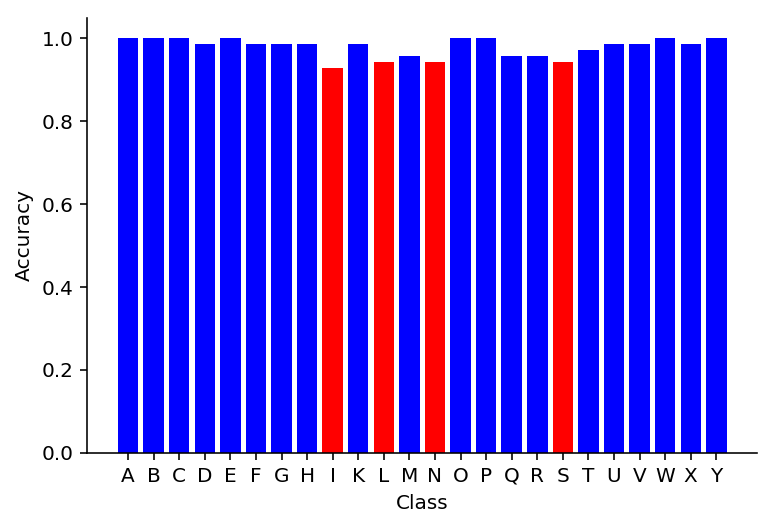

In [96]:
low_acc = accs <= sorted(accs)[3]

plt.bar(letters, accs, color='b')
plt.bar(np.array(letters)[low_acc], accs[low_acc], color='r')
plt.xlabel('Class')
plt.ylabel('Accuracy')
sns.despine()

**End of file**